Preparation of the dataset for the homemade backtest

In [13]:
import pandas as pd
import numpy as np
from numpy import int64
from matplotlib import pyplot as plt
import importlib
import joblib

import sqlite_io as sio
import backtest_portfolio as bp

importlib.reload(bp)

<module 'backtest_portfolio' from 'g:\\Python\\MarketDataEnrichment\\backtest\\backtest_portfolio.py'>

Load datasets

In [16]:
PATH_DATA = "G:\\Python\\Data\\DTS_FULL\\"
df=joblib.load(PATH_DATA+"PARIS_TREND_1D_V5_lab_20_class_5_10_PREDICT_ALL4.pkl")
print(df.shape)



(1233792, 18)


In [17]:
# print different values of predict_5 even NaN
print(df["predict_5"].value_counts(dropna=False))

predict_5
NaN    562222
0.0    162242
3.0    143291
4.0    143128
2.0    138957
1.0     83952
Name: count, dtype: int64


Clean and calculate usefull columns

In [18]:
df = df[df['TRADABLE'] != 0]
df_clean=df.copy()
df_clean=df_clean[ ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME','pos_sma20_200','adx14_pos',
                    'lab_perf_20d_class_5', 'lab_perf_20d_class_10',
                    'predict_10', 'predict_5', 'predict_10_proba', 'predict_5_proba',
                      'PART', 'SHARESOUTSTANDING', 'NAME', 'TRADABLE', 'cap_M']]

print(df_clean.shape)


#TODO PUT THIS FUNCTION IN A LIBRARY
def filter_invalid_values(df_in:pd.DataFrame, column_name:str,debug:bool=False) ->pd.DataFrame:
    """
    Filters out rows where the specified column contains invalid values.

    Args:
        df_in (pd.DataFrame): The DataFrame to filter.
        column_name (str): The name of the column to check.

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    invalid_values = [None, '', 'nan', 'NaN']
    original_count = len(df_in)
    filtered_df = df_in[~df_in[column_name].isin(invalid_values)]
    # Remove rows with np.nan, np.inf, or -np.inf
    filtered_df = filtered_df[filtered_df[column_name].notna()]  # Remove NaN
    filtered_df = filtered_df[~filtered_df[column_name].isin([np.inf, -np.inf])]  # Remove inf and -inf
    
    if debug:
        removed_count = original_count - len(filtered_df)
        print(f"Removed {removed_count} rows from column '{column_name}'")
    return filtered_df

# default value for predict_5 and predict_10 and lab_perf when NaN set to -1
df_clean['predict_5'] = df_clean['predict_5'].fillna(-1)
df_clean['predict_10'] = df_clean['predict_10'].fillna(-1)
df_clean['lab_perf_20d_class_5'] = df_clean['lab_perf_20d_class_5'].fillna(-1)
df_clean['lab_perf_20d_class_10'] = df_clean['lab_perf_20d_class_10'].fillna(-1)

df_clean = filter_invalid_values(df_clean, 'predict_5',True)
df_clean = filter_invalid_values(df_clean, 'predict_10',True)
df_clean = filter_invalid_values(df_clean, 'lab_perf_20d_class_5',True)
df_clean = filter_invalid_values(df_clean, 'lab_perf_20d_class_10',True)

# print values ofwhere  lab_perf_20d_class_5 is not an integer 
# sort by code ascending  then date ascending
df_clean = df_clean.sort_values(by=['CODE', 'OPEN_DATETIME'], ascending=[True, True])

df_clean['SHARESOUTSTANDING']=df_clean['SHARESOUTSTANDING'].fillna(0)
df_clean['SHARESOUTSTANDING']=df_clean['SHARESOUTSTANDING'].replace('',0)
df_clean['SHARESOUTSTANDING']=df_clean['SHARESOUTSTANDING'].astype(int64)

#TODO  REVIEW THIS PART
df_clean['lab_perf_20d_class_10'] = df_clean['lab_perf_20d_class_10'].astype(int64).astype(str)
df_clean['lab_perf_20d_class_5'] = df_clean['lab_perf_20d_class_5'].astype(int64).astype(str)
df_clean['lab_perf_20d_class_5_10'] = (df_clean['lab_perf_20d_class_5'] + df_clean['lab_perf_20d_class_10']).astype(str).str.zfill(2)
df_clean['predict_10'] = df_clean['predict_10'].astype(int64).astype(str)
df_clean['predict_5'] = df_clean['predict_5'].astype(int64).astype(str)
df_clean['predict_5_10'] = (df_clean['predict_5'] + df_clean['predict_10']).astype(str).str.zfill(2)
# 

df_clean['NAME']=df_clean['NAME'].astype(str)
df_clean['day'] = df_clean.index.get_level_values(0)
df_clean['weekday'] = df_clean['day'].dt.weekday
df_clean['week_YYYYWW']=df_clean['day'].dt.strftime('%Y%W')
df_clean['is_last_day_week'] = df_clean.groupby('week_YYYYWW')['day'].transform(lambda x: x == x.max())
df_clean['code_order'] = df_clean.groupby('OPEN_DATETIME')['cap_M'].rank(ascending=False, method='first')
df_clean['next_open'] = df_clean.groupby('CODE')['OPEN'].shift(-1)

print(df_clean.shape)

# drop lines where predicted_score is null or empty or nan
print(df_clean.head())
# df_clean.round(5).to_csv(PATH_DATA+"PARIS_TREND_1D_LSTM_20D_50D_V1_BT.zip", sep=",")


(1233792, 18)
Removed 0 rows from column 'predict_5'
Removed 0 rows from column 'predict_10'
Removed 0 rows from column 'lab_perf_20d_class_5'
Removed 0 rows from column 'lab_perf_20d_class_10'
(1233792, 26)
                      OPEN   HIGH    LOW  CLOSE   VOLUME  pos_sma20_200  \
OPEN_DATETIME CODE                                                        
2010-04-26    AB.PA  12.98  12.98  12.20  12.68  62866.0            NaN   
2010-04-27    AB.PA  12.74  12.83  12.61  12.70  22370.0            NaN   
2010-04-28    AB.PA  12.70  12.70  12.41  12.50   8211.0            NaN   
2010-04-29    AB.PA  12.60  12.65  12.46  12.64   4676.0            NaN   
2010-04-30    AB.PA  12.63  12.71  12.55  12.65   4470.0            NaN   

                     adx14_pos lab_perf_20d_class_5 lab_perf_20d_class_10  \
OPEN_DATETIME CODE                                                          
2010-04-26    AB.PA        NaN                   -1                    -1   
2010-04-27    AB.PA        NaN     

In [19]:
# add a column with Year*12+Month
df_clean['YYMM_int'] = (df_clean['day'].dt.year-2000) * 12 + df_clean['day'].dt.month
print(df_clean['YYMM_int'].min(),df_clean['YYMM_int'].max())

-107 289


In [20]:
# print the list of CODE where a month is missed between to values of YYMM_int
missing_dates_codes = []

# Group by CODE and check for gaps in YYMM_int
for code, group in df_clean.groupby('CODE'):
    group = group.sort_values('YYMM_int')  # Sort by YYMM_int
    gaps = group['YYMM_int'].diff()  # Calculate differences between consecutive YYMM_int
    if (gaps > 1).any():  # Check if any gap is greater than 1
        missing_dates_codes.append(code)

# Print the list of codes with missing dates
print("Codes with missing dates in YYMM_int:", missing_dates_codes)

Codes with missing dates in YYMM_int: []


In [20]:
list_exit_code_5=['-1','0','1','2']
list_exit_code_10=['-1','0','1','2','3','4','5']
list_entry_code_5=['3','4']
list_entry_code_10=['7','8','9']

val_pos=1000
SL=0.2


df_clean['exit_code'] = np.where(
    df_clean['predict_5'].isin(list_exit_code_5) | (df_clean['predict_10'].isin(list_exit_code_10)) , 1, 0) 

#exit with 2 consecutive days of exit code 1 and last day of week
df_clean['exit'] = ((df_clean['exit_code']==1) & (df_clean['exit_code'].shift(1)==1) & (df_clean['is_last_day_week'] ==1)).astype(int)

df_clean['entry_code'] = np.where(
    df_clean['predict_5'].isin(list_entry_code_5) & df_clean['predict_10'].isin(list_entry_code_10) , 1, 0) 
df_clean['entry_2d'] = ((df_clean['entry_code']==1) & (df_clean['entry_code'].shift(1)==1)).astype(int) 
df_clean['entry'] = (df_clean['entry_2d'] == 1) & (df_clean['is_last_day_week'] ==1) 

df_clean['entry_adx'] = (df_clean['entry'] == 1) & (df_clean['adx14_pos'] > 20)

df_clean['qtt']=np.floor(val_pos/df_clean['next_open'])
df_clean['SL']=df_clean['CLOSE']*(1-SL)

df_clean.head()


,,OPEN,HIGH,LOW,CLOSE,VOLUME,pos_sma20_200,adx14_pos,lab_perf_20d_class_5,lab_perf_20d_class_10,predict_10,...,next_open,YYMM_int,exit_code,exit,entry_code,entry_2d,entry,entry_adx,qtt,SL
OPEN_DATETIME,CODE,,,,,,,,,,,,,,,,,,,,,
2010-04-26,AB.PA,12.98,12.98,12.20,12.68,62866.0,NaN,NaN,-1,-1,-1,...,12.74,124,1,0,0,0,False,False,78.0,10.144
2010-04-27,AB.PA,12.74,12.83,12.61,12.70,22370.0,NaN,NaN,-1,-1,-1,...,12.70,124,1,0,0,0,False,False,78.0,10.160
2010-04-28,AB.PA,12.70,12.70,12.41,12.50,8211.0,NaN,NaN,-1,-1,-1,...,12.60,124,1,0,0,0,False,False,79.0,10.000
2010-04-29,AB.PA,12.60,12.65,12.46,12.64,4676.0,NaN,NaN,-1,-1,-1,...,12.63,124,1,0,0,0,False,False,79.0,10.112
2010-04-30,AB.PA,12.63,12.71,12.55,12.65,4470.0,NaN,NaN,-1,-1,-1,...,12.70,124,1,1,0,0,False,False,78.0,10.120


In [21]:
df_clean['cap_filter'] = df_clean['cap_M'].where(df_clean['entry'] == 1, None)
df_clean['entry_order'] = df_clean.groupby('OPEN_DATETIME')['cap_filter'].rank(ascending=False, method='first')
df_clean['entry_filter'] = df_clean['entry_order'] <= 20

df_clean['cap_filter_adx'] = df_clean['cap_M'].where(df_clean['entry_adx'] == 1, None)
df_clean['entry_order_adx'] = df_clean.groupby('OPEN_DATETIME')['cap_filter_adx'].rank(ascending=False, method='first')
df_clean['entry_filter_adx'] = df_clean['entry_order_adx'] <= 20

# df_clean.round(5).to_csv(PATH_DATA+"PARIS_TREND_1D_LGBM_20D_V1_BT_PREPA.zip", sep=",")
# save in pkl
df_clean.to_pickle(PATH_DATA+"PARIS_TREND_1D_LSTM_20D_50D_V1_BT_PREPA.pkl")

In [22]:
# filter df_clean on code AI.PA and ABCA.PA
df_clean_b = df_clean[df_clean.index.get_level_values('CODE').isin([ 'ABCA.PA'])]
print(df_clean_b.shape)
df_clean_b.round(5).to_csv(PATH_DATA+"PARIS_TREND_1D_LGBM_20D_V1_BT_PREPA_SAMPLE.zip", sep=",")

(6156, 41)


-- break point

In [22]:
PATH_DATA = "G:\\Python\\Data\\DTS_FULL\\"
# df_saved=pd.read_csv(PATH_DATA+"PARIS_TREND_1D_LGBM_20D_V1_BT_PREPA.zip",sep=",",parse_dates=['OPEN_DATETIME','day'],index_col=['CODE','OPEN_DATETIME'])
# load pkl file 
df_saved=pd.read_pickle(PATH_DATA+"PARIS_TREND_1D_LSTM_20D_50D_V1_BT_PREPA.pkl")
print(df_saved.shape)

(1233792, 41)


In [25]:
# filter out rows where 'entry' is 0 and 'exit' is 0
distinct_codes = df_saved[df_saved['entry_filter'] == 1].index.get_level_values('CODE').unique()
codes_not_in_distinct = df_saved[~df_saved.index.get_level_values('CODE').isin(distinct_codes)].index.get_level_values('CODE').unique().tolist()
print(f"{len(distinct_codes)=}-{len(codes_not_in_distinct)=}")

df_clean = df_saved[~df_saved.index.get_level_values('CODE').isin(codes_not_in_distinct)]
print(df_clean.shape)

# df_clean.round(5).to_csv(PATH_DATA+"PARIS_TREND_1D_LGBM_20D_V1_BT_PREPA_FILTERED.zip", sep=",")

len(distinct_codes)=263-len(codes_not_in_distinct)=15
(1215649, 41)


In [23]:
PATH_DATA = "G:\\Python\\Data\\DTS_FULL\\"
df_prepa=pd.read_pickle(PATH_DATA+"PARIS_TREND_1D_LSTM_20D_50D_V1_BT_PREPA.pkl")
#entry, exit, price, low, sl, priority, nb_stocks
print(df_prepa.shape)

(1233792, 41)


In [26]:
# print list columns
print(df_prepa.columns.tolist())
# print type of predict_5_proba
print(df_prepa['predict_5_proba'].dtype)
# print list of index levels
print(df_prepa.index.names)

['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'pos_sma20_200', 'adx14_pos', 'lab_perf_20d_class_5', 'lab_perf_20d_class_10', 'predict_10', 'predict_5', 'predict_10_proba', 'predict_5_proba', 'PART', 'SHARESOUTSTANDING', 'NAME', 'TRADABLE', 'cap_M', 'lab_perf_20d_class_5_10', 'predict_5_10', 'day', 'weekday', 'week_YYYYWW', 'is_last_day_week', 'code_order', 'next_open', 'YYMM_int', 'exit_code', 'exit', 'entry_code', 'entry_2d', 'entry', 'entry_adx', 'qtt', 'SL', 'cap_filter', 'entry_order', 'entry_filter', 'cap_filter_adx', 'entry_order_adx', 'entry_filter_adx']
object
['OPEN_DATETIME', 'CODE']


In [29]:
# keep line between 2000 and 2016-12-31
df_prepa_bt=df_prepa.copy()
df_prepa_bt = df_prepa_bt[(df_prepa_bt.index.get_level_values('OPEN_DATETIME') >= '2006-01-01') & (df_prepa_bt.index.get_level_values('OPEN_DATETIME') <= '2016-12-31')]

# drop lines after 2023-11-18
# df_prepa_bt = df_prepa_bt[df_prepa_bt.index.get_level_values('day') <= '2015-10-10']#'2023-10-10'

# df_prepa_bt.round(5).to_csv(PATH_DATA+"PARIS_TREND_1D_LGBM_20D_V1_BT_SAMPLE.zip", sep=",")

# add column comment with the value ofpredict_5_10 and predict_5_proba
df_prepa_bt['predict_5_proba'] = df_prepa_bt['predict_5_proba'].apply(
    lambda x: [round(float(value), 4) for value in x] if isinstance(x, list) else round(float(x), 4) if pd.notna(x) else x
)
df_prepa_bt['predict_10_proba'] = df_prepa_bt['predict_10_proba'].apply(
    lambda x: [round(float(value), 4) for value in x] if isinstance(x, list) else round(float(x), 4) if pd.notna(x) else x
)
df_prepa_bt['comment'] = df_prepa_bt['lab_perf_20d_class_5_10'].astype(str) + ' ' + df_prepa_bt['predict_5_10'].astype(str) + ' ' + df_prepa_bt['predict_5_proba'].astype(str)+ ' ' + df_prepa_bt['predict_10_proba'].astype(str)

df_bt=df_prepa_bt[['LOW','next_open','exit','qtt','SL','entry_order','entry_filter','comment']]

df_bt = df_bt.rename(columns={'entry_filter': 'entry', 'next_open': 'price', 'LOW': 'low', 'SL': 'sl',
                               'qtt': 'quantity','entry_order':'priority'})

df_bt.describe()


,low,price,exit,quantity,sl,priority
count,540345.000000,540345.000000,540345.000000,540345.000000,540345.000000,14034.000000
mean,31.693254,32.120328,0.155800,117.882545,25.683175,19.574462
std,100.276529,101.904559,0.362666,191.170847,81.471992,15.565496
min,0.274500,0.282800,0.000000,0.000000,0.219600,1.000000
25%,8.043800,8.147900,0.000000,30.000000,6.512960,8.000000
50%,17.164800,17.391500,0.000000,57.000000,13.905360,16.000000
75%,32.880200,33.271200,0.000000,122.000000,26.611600,28.000000
max,2598.643300,2654.819800,1.000000,3536.000000,2116.773280,98.000000


In [36]:
initial_cash = 10000
commission = 0.006
freq_print=20
log_to_file=True

options = {'max_positions': 5, 'scale_up': False, 'sell_all': True, 'fixe_quantity':False}

remaining_portfolio = bp.backtest_strategy_portfolio(df_in=df_bt, initial_cash=initial_cash,
                                                      commission=commission,options=options,freq_print=freq_print,
                                                      log_to_file=log_to_file)
print(f'Remaining portfolio: {remaining_portfolio}')
print(f'{remaining_portfolio.nb_trades= } {remaining_portfolio.total_commission= }')

# https://www.boursorama.com/bourse/trackers/cours/1rTCACC/
# FR0013380607
# CAC40 GR au 2020-08-17 : 21.5 
# CAC40 GR au 2023-10-10 : 32.66 soit 51.9% de perf

# PTF au 2020-08-17 : 10000
# PTF au 2023-11-18 SMA ADX : 

Logging to file: g:\Python\MarketDataEnrichment\backtest/logs/
Remaining portfolio: Portfolio: cash=12826.63, nb_positions=0, value=12903.82, positions= 
remaining_portfolio.nb_trades= 1336 remaining_portfolio.total_commission= 21444.256144200004


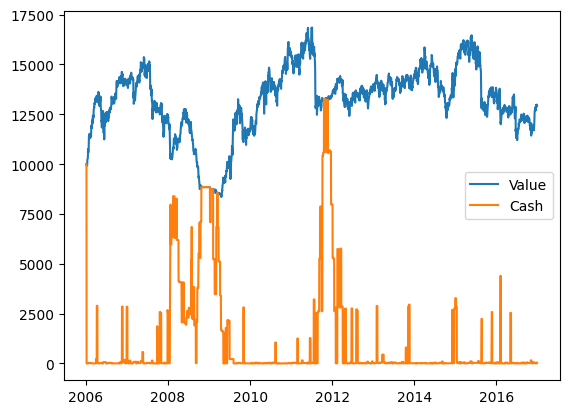

In [37]:
# print graphic history of portfolio with matplotlib
plt.plot(remaining_portfolio.history['date'], remaining_portfolio.history['value'], label='Value')
plt.plot(remaining_portfolio.history['date'], remaining_portfolio.history['cash'], label='Cash')
# plt.plot(remaining_portfolio.history['date'], remaining_portfolio.history['value'] - remaining_portfolio.history['cash'], label='Invested')
plt.legend()
plt.show()


